# Non-linear latent variable models

Non-linear latent variable models are a class of statistical models that involve a set of latent (unobserved) variables that are related to observed variables through a non-linear relationship. These models are used to work with complex data sets. Some examples of non-linear latent variable models are autoencoders, variational autoencoders, and generative adversarial networks.

Linear latent variable models and non-linear latent variable models are both types of statistical models that involve a set of latent variables. However, linear latent variable models assume that the relationship between the latent variables and the observed variables is linear. On the other hand, non-linear latent variable models assume that the relationship between the latent variables and the observed variables is non-linear. This means that the relationship cannot be represented by a linear equation, but by a more complex mathematical function, such as polynomials or neural networks.

Apply VAE on a computer vision dataset

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
class CVAE(tf.keras.Model):

    def __init__(self, latent_dim, batch_size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    def call(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=(self.batch_size, self.latent_dim))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [5]:
def log_normal_pdf(sample, mean, logvar, raxis=1):

    log2pi = tf.math.log(2.0 * np.pi)

    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):

    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [24]:
@tf.function
def train_step(model, x, optimizer):

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [25]:
# Load data
data = np.load('data/mnist_data.npy', allow_pickle=True).astype(np.float32)
target = np.load('data/mnist_labels.npy', allow_pickle=True).astype(np.float32)

# Preprocess data
data = data.reshape(-1, 28, 28, 1) / 255.0

# Split data into train, validation, and test sets
n = 10000
m = 2000
k = 2000

x_train = data[:n]
y_train = target[:n]

x_val = data[n:n + m]
y_val = target[n:n + m]

x_test = data[n + m:n + m + k]
y_test = target[n + m:n + m + k]

In [26]:
epochs = 30
latent_dim = 2
batch_size = 50
optimizer = tf.keras.optimizers.Adam(1e-4)

model = CVAE(latent_dim, batch_size)

# Train the model
for epoch in range(1, epochs + 1):

    # Training steps
    for i in range(n // batch_size):
        train_step(model, x_train[i:i + batch_size], optimizer)

    # Validation steps
    r_val = m // batch_size
    loss = tf.keras.metrics.Mean()
    elbo = 0

    for i in range(r_val):
        loss(compute_loss(model, x_val[i:i + batch_size]))
        elbo += -loss.result()

    elbo /= r_val

    # Print validation results
    print('Epoch: {}, Validation set ELBO: {}'.format(epoch, elbo))

Epoch: 1, Validation set ELBO: -280.3813781738281
Epoch: 2, Validation set ELBO: -224.1057891845703
Epoch: 3, Validation set ELBO: -212.5828857421875
Epoch: 4, Validation set ELBO: -205.65719604492188
Epoch: 5, Validation set ELBO: -202.78599548339844
Epoch: 6, Validation set ELBO: -198.54356384277344
Epoch: 7, Validation set ELBO: -194.4754180908203
Epoch: 8, Validation set ELBO: -192.05844116210938
Epoch: 9, Validation set ELBO: -190.8883819580078
Epoch: 10, Validation set ELBO: -190.55081176757812
Epoch: 11, Validation set ELBO: -190.02987670898438
Epoch: 12, Validation set ELBO: -190.39035034179688
Epoch: 13, Validation set ELBO: -189.65980529785156
Epoch: 14, Validation set ELBO: -189.5915069580078
Epoch: 15, Validation set ELBO: -189.54043579101562
Epoch: 16, Validation set ELBO: -190.09451293945312
Epoch: 17, Validation set ELBO: -191.02122497558594
Epoch: 18, Validation set ELBO: -192.7210235595703
Epoch: 19, Validation set ELBO: -193.8519287109375
Epoch: 20, Validation set ELB

In [27]:
# Save the model
path = 'output/vae-mnist-models/model_weights.h5'
model.save_weights(path, save_format='h5')

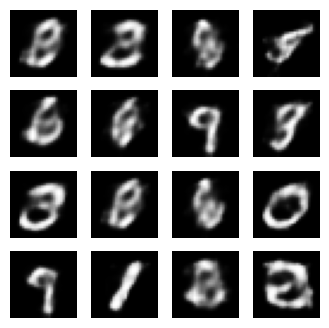

In [28]:
# Plot model reconstructions
model = CVAE(latent_dim, k)

# Load weights
model(x_test)  # For input dimension specification
model.load_weights(path)

# Feed-forward to get predictions
mean, logvar = model.encode(x_test)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)

# Plot outputs
n_samples = 16
m_samples = np.sqrt(n_samples).astype(np.int32)
fig = plt.figure(figsize=(m_samples, m_samples))

for i in range(n_samples):
    plt.subplot(m_samples, m_samples, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

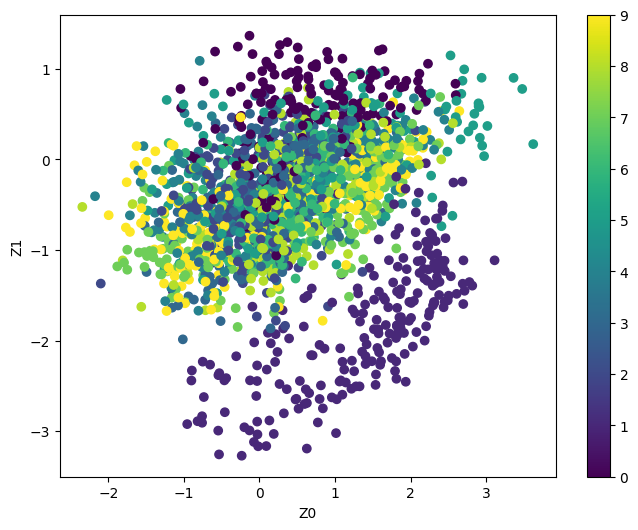

In [30]:
# Plot the latent space
plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Z0")
plt.ylabel("Z1")
plt.show()


Apply VAE on a molecular dataset